# **BPM Prediction Challenge**

### Steps:
1. Base model implementation
2. Feature transformation and model implementation
3. Hyperparameter tuning

Additional Models:
1. Deep Neural Network
2. Stacking - Ensemble learning

In [ ]:
!pip install xgboost

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
import lightgbm as lgb


import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e9/sample_submission.csv
/kaggle/input/playground-series-s5e9/train.csv
/kaggle/input/playground-series-s5e9/test.csv


In [ ]:
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
train = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")
train.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [ ]:
test.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,524164,0.410013,-16.794967,0.023500,0.232910,0.012689,0.271585,0.664321,302901.5498,0.424867
1,524165,0.463071,-1.357000,0.141818,0.057725,0.257942,0.097624,0.829552,221995.6643,0.846000
2,524166,0.686569,-3.368928,0.167851,0.287823,0.210915,0.325909,0.304978,357724.0127,0.134067
3,524167,0.885793,-5.598049,0.118488,0.000005,0.376906,0.134435,0.487740,271790.3989,0.316467
4,524168,0.637391,-7.068160,0.126099,0.539073,0.068950,0.024300,0.591248,277728.5383,0.481067


In [ ]:
#No null values and data types are accurate
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         524164 non-null  int64  
 1   RhythmScore                524164 non-null  float64
 2   AudioLoudness              524164 non-null  float64
 3   VocalContent               524164 non-null  float64
 4   AcousticQuality            524164 non-null  float64
 5   InstrumentalScore          524164 non-null  float64
 6   LivePerformanceLikelihood  524164 non-null  float64
 7   MoodScore                  524164 non-null  float64
 8   TrackDurationMs            524164 non-null  float64
 9   Energy                     524164 non-null  float64
 10  BeatsPerMinute             524164 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 44.0 MB


In [ ]:
#No duplicates
train.duplicated().sum()

0

In [ ]:
train.describe()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
count,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000
mean,262081.500000,0.632843,-8.379014,0.074443,0.262913,0.117690,0.178398,0.555843,241903.692949,0.500923,119.034899
std,151313.257586,0.156899,4.616221,0.049939,0.223120,0.131845,0.118186,0.225480,59326.601501,0.289952,26.468077
min,0.000000,0.076900,-27.509725,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067,46.718000
25%,131040.750000,0.515850,-11.551933,0.023500,0.069413,0.000001,0.077637,0.403921,207099.876625,0.254933,101.070410
50%,262081.500000,0.634686,-8.252499,0.066425,0.242502,0.074247,0.166327,0.564817,243684.058150,0.511800,118.747660
75%,393122.250000,0.739179,-4.912298,0.107343,0.396957,0.204065,0.268946,0.716633,281851.658500,0.746000,136.686590
max,524163.000000,0.975000,-1.357000,0.256401,0.995000,0.869258,0.599924,0.978000,464723.228100,1.000000,206.037000


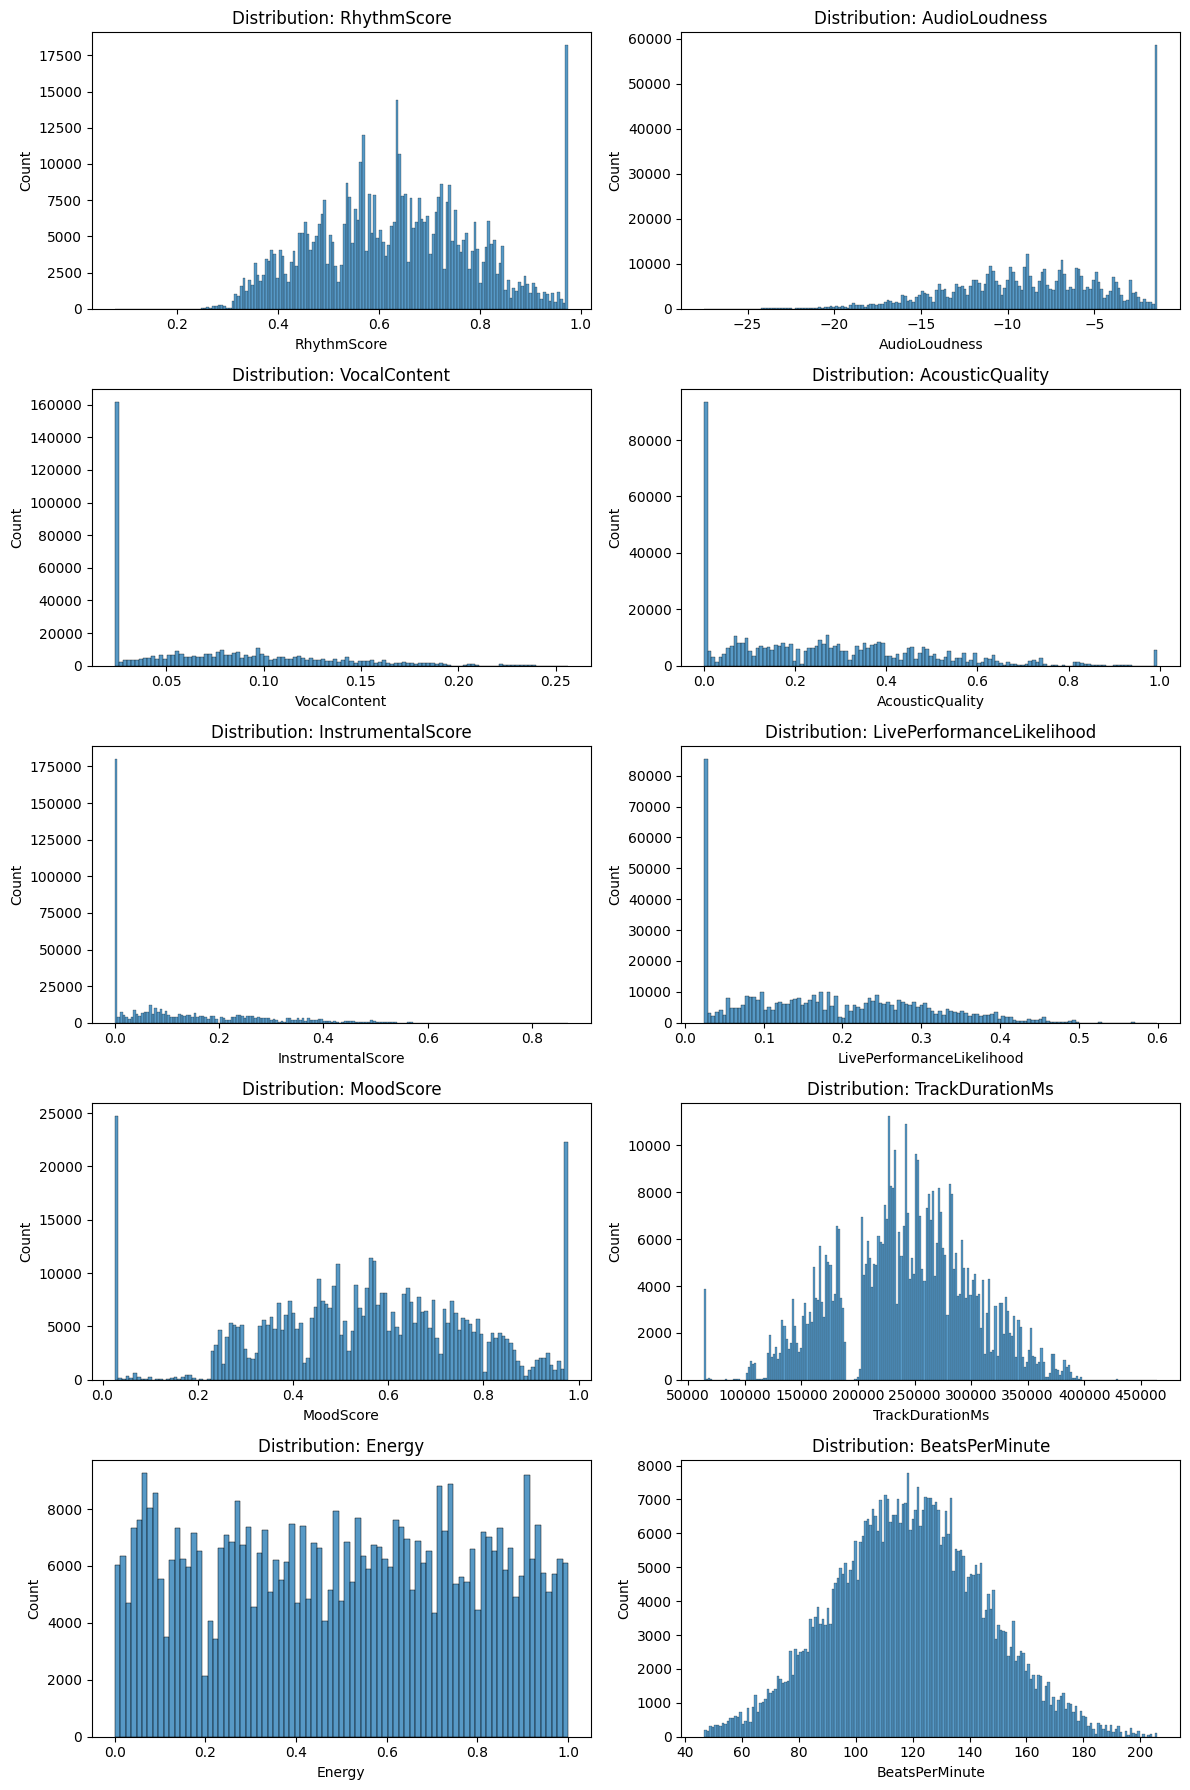

In [ ]:
#Visualizing the distribution for each column in the data
fig, axes = plt.subplots(nrows = 5,ncols = 2, figsize = (12,18))
axes = axes.flatten()
cols = train.columns[1:]
for i in range(len(cols)):
    sns.histplot(x = train[cols[i]], ax = axes[i])
    axes[i].set_title("Distribution: " + cols[i])

plt.tight_layout()
plt.show()

In [ ]:
# Splitting the data into train and test from the train.csv itself
x,y = train.iloc[:,1:-1], train.iloc[:, -1]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25, random_state = 47)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(393123, 9) (131041, 9) (393123,) (131041,)


In [ ]:
#Fitting multiple models and checking the best performance as an initial check
#For the ensemble models, only 10 estimators are chosen to reduce training time, since the data is huge.
models = {
    'LinearRegression': LinearRegression(),
    'Lasso':Lasso(random_state = 47),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state = 47),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'RandomForestRegressor':RandomForestRegressor(n_estimators = 10,random_state = 47),
    'AdaBoostRegressor':AdaBoostRegressor(n_estimators = 10,random_state = 47),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators = 10,random_state = 47),
    'XGBoostRegressor': XGBRegressor(n_estimators = 10,random_state = 47),
    "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators = 10, random_state = 47),
    "LGBM": lgb.LGBMRegressor(random_state= 47, verbose = -1)
}

best_rmse = 1000
best_model = None

for name, model in models.items():
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    error = np.sqrt(mean_squared_error(ytest, ypred))

    print(f"{name} RMSE: {error}")

    if best_rmse >error:
        best_rmse = error
        best_model = name

print(f"\nBest Model: {best_model}, Best RMSE: {best_rmse}")

LinearRegression RMSE: 26.474561099830563
Lasso RMSE: 26.47468701662729
DecisionTreeRegressor RMSE: 38.32714402463827
KNeighborsRegressor RMSE: 28.976122037907643
RandomForestRegressor RMSE: 27.96437724572681
AdaBoostRegressor RMSE: 26.47417081241468
GradientBoostingRegressor RMSE: 26.46861313983795
XGBoostRegressor RMSE: 26.478295359880462
ExtraTreesRegressor RMSE: 28.083373542119052
LGBM RMSE: 26.475925511314966

Best Model: GradientBoostingRegressor, Best RMSE: 26.46861313983795


# Obtaining Output for test data with Linear Regression model

In [ ]:
#Fitting a Linear Regression model
lr = LinearRegression()
lr.fit(x, y)
predictions = lr.predict(x)
error = np.sqrt(mean_squared_error(y, predictions))
print(error)

26.46573730086693


In [ ]:
test_data = test.iloc[:, 1:]
test_predictions = lr.predict(test_data)
output_data = {
    'id': test.iloc[:,0],
    'BeatsPerMinute': test_predictions
}
output = pd.DataFrame(output_data)
output.head()

output.to_csv("submission_lr.csv", index = False)

### Submission RMSE - 26.39266

# Identifying correlation between numerical values

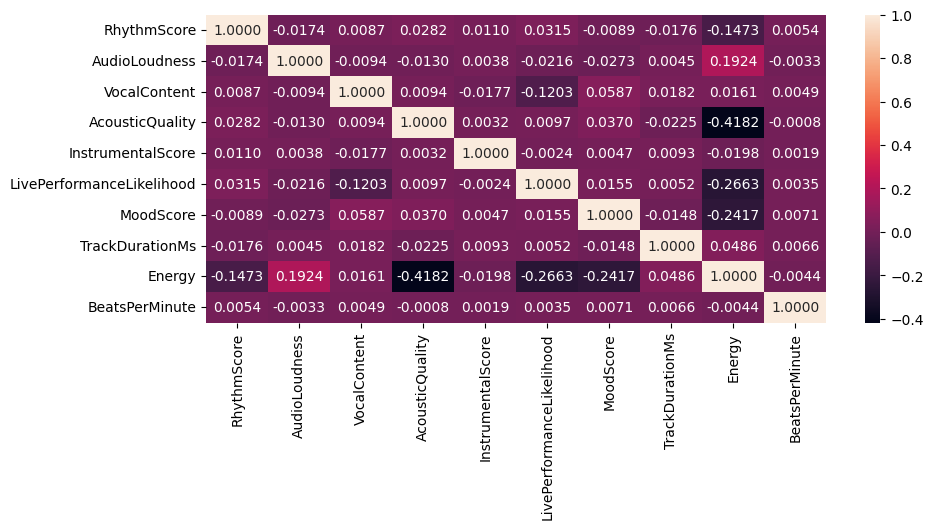

In [ ]:
plt.figure(figsize = (10,4))
sns.heatmap(data = train.iloc[:,1:].corr(),cmap = "rocket", fmt = ".4f", annot = True)
plt.show()

### There seems to be almost no correlation between the input features and the target.

# Feature Transformation

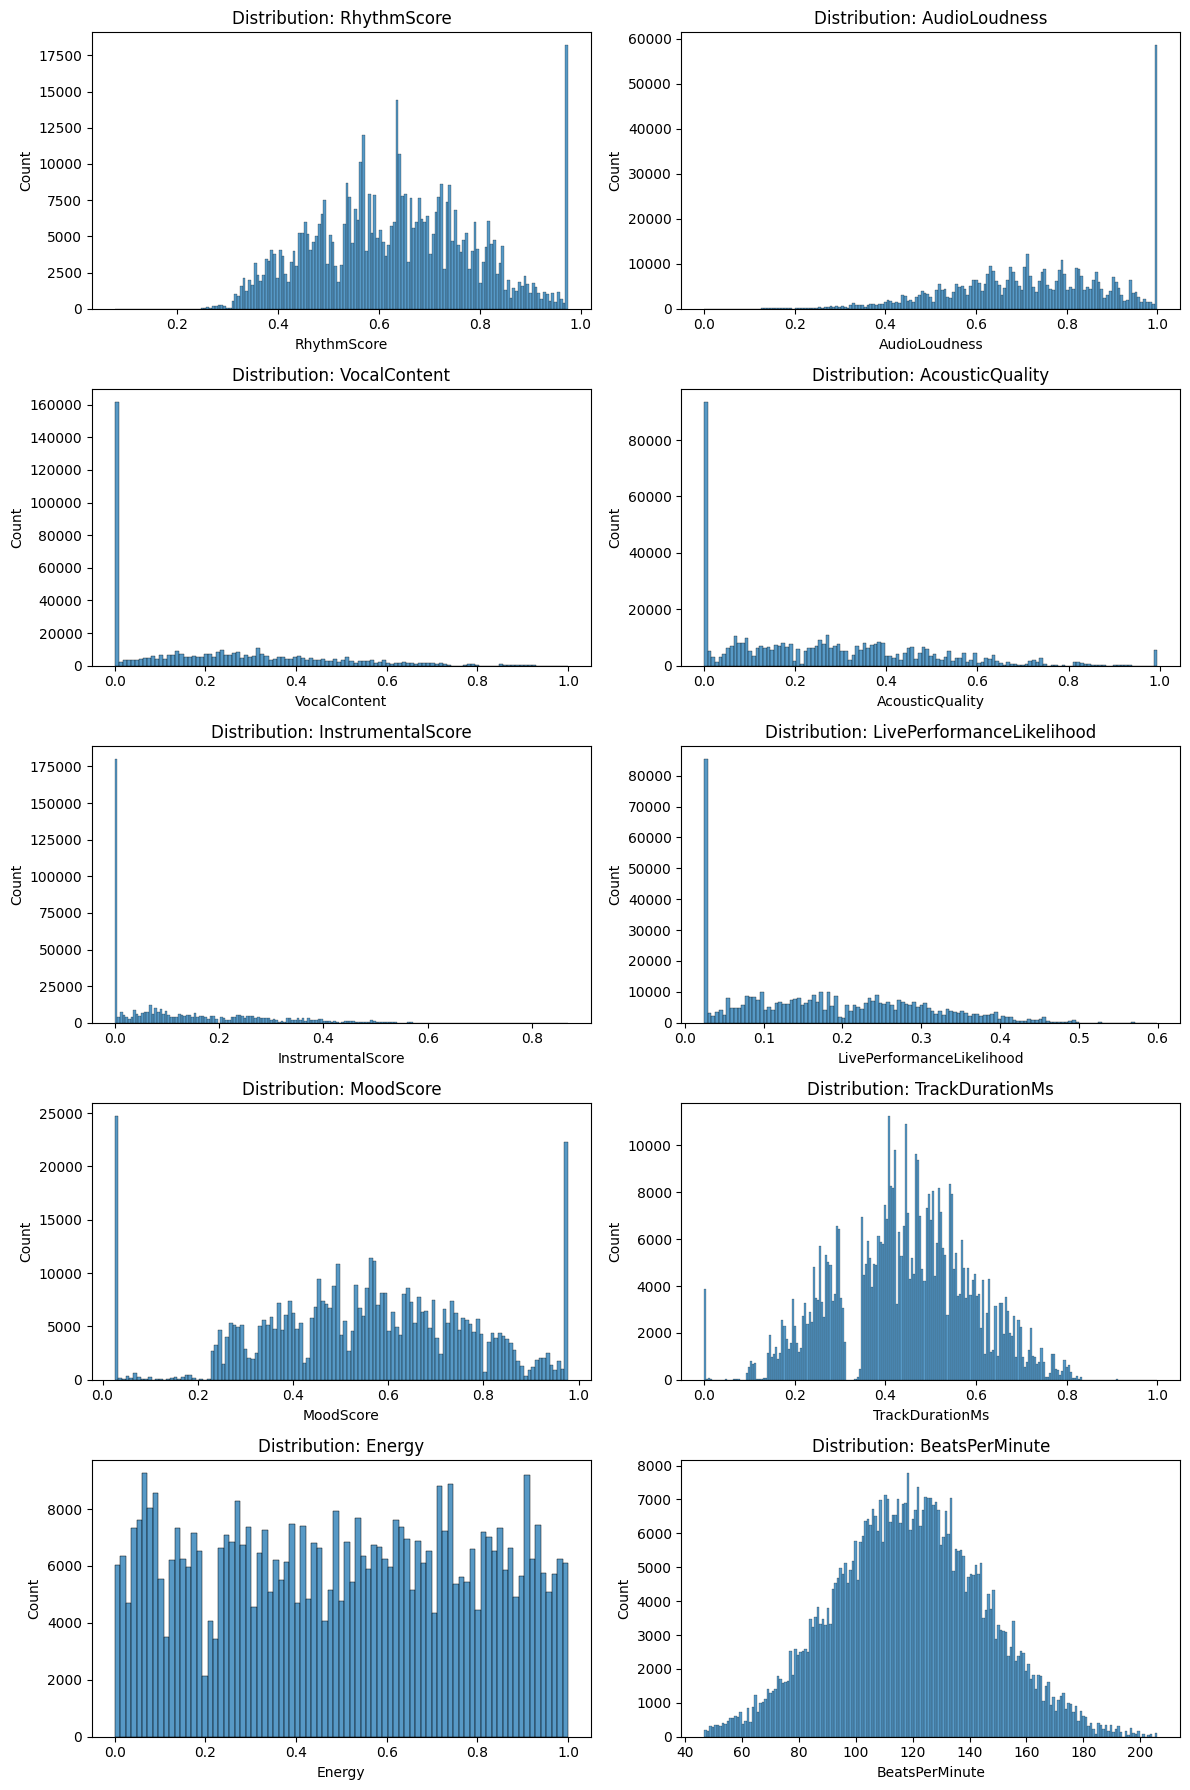

In [ ]:
#Converting the Track Duration to minutes to then perform normalization
def convert_to_mins(x):
    return (x/1000)/60 #converting the time to minutes

train['TrackDurationMs'] = train['TrackDurationMs'].apply(convert_to_mins)
scaler = MinMaxScaler()
train[['AudioLoudness','VocalContent','TrackDurationMs']] = scaler.fit_transform(train[['AudioLoudness','VocalContent','TrackDurationMs']])

#Visualizing the distribution for each column in the data
fig, axes = plt.subplots(nrows = 5,ncols = 2, figsize = (12,18))
axes = axes.flatten()
cols = train.columns[1:]
for i in range(len(cols)):
    sns.histplot(x = train[cols[i]], ax = axes[i])
    axes[i].set_title("Distribution: " + cols[i])

plt.tight_layout()
plt.show()

In [ ]:
# Splitting the data into train and test from the train.csv itself
x,y = train.iloc[:,1:-1], train.iloc[:, -1]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25, random_state = 47)

In [ ]:
#Fitting a Linear Regression model
lr = LinearRegression()
lr.fit(x, y)
predictions = lr.predict(x)
error = np.sqrt(mean_squared_error(y, predictions))
print(error)

26.46573730086693


### Even after applying these transformations, the models did not yield a significant change

# DNN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LeakyReLU
from keras import Sequential

2025-09-28 08:51:56.352863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759049516.661731      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759049516.746848      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
model = Sequential([
    Dense(9, activation = "relu", input_dim = 9), #9 inputs
    Dense(24, activation = 'tanh'),
    Dense(1, activation = "linear") #Since the problem is of regression, hence linear activation function
])

model.compile(optimizer = 'adam', loss='mean_squared_error', metrics = [tf.keras.metrics.RootMeanSquaredError()])

model.summary()

2025-09-28 08:52:10.787390: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 9)              │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355 (1.39 KB)

 Trainable params: 355 (1.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(x, y, epochs = 9, batch_size = 64, verbose = 1)

Epoch 1/9
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 7436.4751 - root_mean_squared_error: 84.4917
Epoch 2/9
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 701.6317 - root_mean_squared_error: 26.4883
Epoch 3/9
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 698.8427 - root_mean_squared_error: 26.4356
Epoch 4/9
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 701.0779 - root_mean_squared_error: 26.4777
Epoch 5/9
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 698.0250 - root_mean_squared_error: 26.4201
Epoch 6/9
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 698.8376 - root_mean_squared_error: 26.4355
Epoch 7/9
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 700.0383 - root_mean_squared_error: 26.4581
Epoch 8/9
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 700.4606 - root_mean_squared_error: 26.4661
Epoch 9/9
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 701.0551 - root_mean_squared_error: 26.4774


In [ ]:
model.evaluate(x, y)

16381/16381 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 701.4879 - root_mean_squared_error: 26.4855


[700.5568237304688, 26.468034744262695]

In [ ]:
test_data = test.iloc[:, 1:]
test_predictions = model.predict(test_data)
output_data = {
    'id': test.iloc[:,0],
    'BeatsPerMinute': test_predictions.flatten()
}
output = pd.DataFrame(output_data)
output.head()

output.to_csv("submission.csv", index = False)

5461/5461 ━━━━━━━━━━━━━━━━━━━━ 4s 781us/step


**Versions of the DNN implemented**<br>
* 1st:<br>
24 neurons with tanh activation.<br>
Best RMSE of 26.4969<br>


* 2nd:<br>
2 layers of 12 neurons with tanh activation <br>
Similar RMSE to the 1st.

* 3rd:<br>
1st layer of 12 neurons with tanh and 2nd with 6 neurons and tanh activation.
RMSE of 26.4984



### Submission RMSE - 26.39514

# Hyperparameter Tuning on GradientBoosting & Lasso

In [ ]:
#Lasso for feature selection
names = train.columns[1:-1]

def lasso(alpha):
    df1 = pd.DataFrame()
    df1['FeatureNames'] = names
    for i in alpha:
        lasso = Lasso(alpha = i)
        lasso.fit(x,y)
        col_name = "Alpha = %f"%i
        df1[col_name] = lasso.coef_

    return df1

lasso([0.0001,0.001,0.01,0.1,0.5,1,10,100])

,FeatureNames,Alpha = 0.000100,Alpha = 0.001000,Alpha = 0.010000,Alpha = 0.100000,Alpha = 0.500000,Alpha = 1.000000,Alpha = 10.000000,Alpha = 100.000000
0,RhythmScore,0.871103,0.838490,0.502121,0.000000,0.000000,0.000000,0.000000,0.000000
1,AudioLoudness,-0.015195,-0.015321,-0.016387,-0.014554,-0.000000,-0.000000,-0.000000,-0.000000
2,VocalContent,2.487916,2.104062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,AcousticQuality,-0.229296,-0.205601,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
4,InstrumentalScore,0.359599,0.305712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,LivePerformanceLikelihood,0.710511,0.631447,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,MoodScore,0.751391,0.740198,0.604526,0.000000,0.000000,0.000000,0.000000,0.000000
7,TrackDurationMs,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
8,Energy,-0.171309,-0.165360,-0.106904,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000


In [ ]:
#Selecting best alpha for Lasso
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, KFold
x = train[['RhythmScore','AudioLoudness','MoodScore','Energy']]

model1 = Lasso()
cv = KFold(n_splits = 10, shuffle = True, random_state = 42)
params = {'alpha':[0.001,0.01,0.1,0.5,1,10]}
grid = GridSearchCV(model1, params, cv = cv)
results = grid.fit(x,y)
print(results.best_params_, results.best_estimator_)

{'alpha': 0.001} Lasso(alpha=0.001)


In [ ]:
#Training a lasso model with the best alpha and selected features
x,y = train[['RhythmScore','AudioLoudness','MoodScore','Energy']], train.iloc[:, -1]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25, random_state = 47)

lasso_model = Lasso(alpha = 0.001)
lasso_model.fit(xtrain, ytrain)
ypred = lasso_model.predict(xtest)
rmse = np.sqrt(mean_squared_error(ytest, ypred))
print(rmse)

26.47430381211408


In [ ]:
test_data = test[['RhythmScore','AudioLoudness','MoodScore','Energy']]
test_predictions = lasso_model.predict(test_data)
output_data = {
    'id': test.iloc[:,0],
    'BeatsPerMinute': test_predictions
}
output = pd.DataFrame(output_data)
output.head()

output.to_csv("submission.csv", index = False)

### Submission RMSE - 26.39253

# Stacking Regressor with the best models found from the multi model training

In [ ]:
# Splitting the data into train and test from the train.csv itself
x,y = train[['RhythmScore','AudioLoudness','MoodScore','Energy']], train.iloc[:, -1]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25, random_state = 47)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(393123, 4) (131041, 4) (393123,) (131041,)


In [ ]:
#Defining a function to create a stacking model
def get_stacking():
  level0 = list()  #Init an empty list to hold all models
  level0.append(('knn',KNeighborsRegressor()))
  level0.append(('rf', RandomForestRegressor(n_estimators = 15)))
  level0.append(('gbm', GradientBoostingRegressor(n_estimators = 15)))
  level1 = LinearRegression()
  model = StackingRegressor(estimators = level0, final_estimator = level1) #Combine base models and meta models
  return model

smodel = get_stacking()
smodel.fit(x, y)
ypred = smodel.predict(x)
rmse = np.sqrt(mean_squared_error(y, ypred))
print(rmse)

26.385552467333078


In [ ]:
test_data = test[['RhythmScore','AudioLoudness','MoodScore','Energy']]
test_predictions = smodel.predict(test_data)
output_data = {
    'id': test.iloc[:,0],
    'BeatsPerMinute': test_predictions
}
output = pd.DataFrame(output_data)
output.head()

output.to_csv("submission1.csv", index = False)

### Submission RMSE - 26.39081 - Best RMSE for this notebook across all the models